# Reddit Project Starter Script

### Putting data into your own bucket

In the following cell, you will copy your assigned subreddit from the central teaching bucket to your own persaonl bucket. This cell MUST only be executed once per account!!

In [ ]:
# already ran this in the terminal
#!aws s3 cp s3://bigdatateaching/reddit/subreddits/[[YOUR-SUBREDDIT-NAME]]/ s3://[[YOUR-BUCKET-NAME]]/reddit --recursive

### Reading your entire dataset

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark.sql.functions as f
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

In [3]:
from pyspark.sql.functions import isnan, when, count, sum, to_timestamp, dayofweek, hour, minute, second #, percentile_approx
from pyspark.sql.types import IntegerType

In [4]:
spark = SparkSession.builder.appName("reddit").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/04 01:10:26 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


Make sure your SparkSession is active:

In [5]:
spark

In [6]:
df_full = spark.read.parquet('s3://ms4684-projectdata/reddit')

In [7]:
df_full.count()

22/05/04 01:10:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


41321070

There are 41.3 million records in the dataset.

### Reading one month worth of data

In [ ]:
# run in terminal (without !)
#!aws s3 ls s3://ms4684-projectdata/reddit/

In [8]:
df = spark.read.parquet('s3://ms4684-projectdata/reddit/ym_partition=202106')

In [9]:
df.count()

1434016

The data for the one month that we have read in has 1.4 million records.

### Developing on a small piece of your data

It's helpful to develop a small piece of data to test code on before running the code on the full dataset.

In [10]:
# selecting 10,000 records
df_small = df.limit(10000)

In [11]:
# check count
df_small.count()

10000

### Explortatory Analysis

- Explore, assess and visualize the data.
- Aggregate, count, and summarize.
- Create graphs, tables, etc, and explain your findings in writing.
- Clean data if necessary.
- Extract useful information from the text of the comments to create additional variables in your dataset.

In [12]:
# number of rows
df_full.count()

41321070

In [13]:
# view the first 5 rows
df_full.show(5)

+-------------+----------------+-----------------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+--------------------+--------------+--------+--------------------+--------+------------+---------+-------------------------------+----------------+------------+----------------+-----------+-------------+------+------+--------+-------+------------+---------+------+---------+----------+--------------------+-----------+--------------+------------+-----+------------+--------+------------+-----------------------+--------------+----------------+---------------------+--------------+--------------+--------+--------------+------------+
|all_awardings|associated_award|           author|author_created_utc|author_flair_background_color|author_flair_css_class|author_flair_richtext|author_flair_template_id|author_flair_text|author_flair_text_color|author_flai

Difficult to see interpret this output. Let's convert this into a Pandas dataframe and view again. Will be using a sample of the full dataframe for this.

In [14]:
df_small.toPandas().iloc[1:5,:]

,all_awardings,associated_award,author,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,stickied,subreddit_id,subreddit_name_prefixed,subreddit_type,top_awarded_type,total_awards_received,treatment_tags,author_cakeday,editable,media_metadata
1,[],None,JacksMovingFinger,1.420157e+09,None,None,[],None,None,None,...,False,t5_2tk0s,None,public,None,0,[],None,None,nan
2,[],None,drizzitdude,1.398159e+09,None,None,[],None,None,None,...,False,t5_2tk0s,None,public,None,0,[],None,None,nan
3,[],None,gabrielmaster123,1.539273e+09,None,None,[],None,None,None,...,False,t5_2tk0s,None,public,None,0,[],None,None,nan
4,[],None,[deleted],NaN,,None,nan,None,None,dark,...,False,t5_2tk0s,None,public,None,0,[],None,None,nan


In [15]:
# print schema
df_full.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- collapsed_because_crowd_control: string (nullable = true)
 |-- collapsed_reason: 

In [16]:
# check number of columns
len(df_full.columns)

51

The dataset has 51 variables.

In [17]:
# check data types
df_full.dtypes

[('all_awardings', 'string'),
 ('associated_award', 'string'),
 ('author', 'string'),
 ('author_created_utc', 'double'),
 ('author_flair_background_color', 'string'),
 ('author_flair_css_class', 'string'),
 ('author_flair_richtext', 'string'),
 ('author_flair_template_id', 'string'),
 ('author_flair_text', 'string'),
 ('author_flair_text_color', 'string'),
 ('author_flair_type', 'string'),
 ('author_fullname', 'string'),
 ('author_patreon_flair', 'boolean'),
 ('author_premium', 'boolean'),
 ('awarders', 'string'),
 ('body', 'string'),
 ('can_gild', 'boolean'),
 ('can_mod_post', 'boolean'),
 ('collapsed', 'boolean'),
 ('collapsed_because_crowd_control', 'string'),
 ('collapsed_reason', 'string'),
 ('comment_type', 'string'),
 ('controversiality', 'bigint'),
 ('created_utc', 'bigint'),
 ('distinguished', 'string'),
 ('edited', 'double'),
 ('gilded', 'bigint'),
 ('gildings', 'string'),
 ('id', 'string'),
 ('is_submitter', 'boolean'),
 ('link_id', 'string'),
 ('locked', 'boolean'),
 ('no_f

Most of the data seems to have the correct data type, but I will be exploring what the columns mean below and will assess the data type accordingly, changing it when needed.

In [18]:
# check for missing data
for col in df_full.columns:
    print(col, df_full.filter(df_full[col].isNull()).count())

all_awardings 0
associated_award 0


author 2


author_created_utc 19157122
author_flair_background_color 34369570
author_flair_css_class 39493734
author_flair_richtext 0
author_flair_template_id 39372864
author_flair_text 39297538


author_flair_text_color 33472270
author_flair_type 5825920


author_fullname 5825920
author_patreon_flair 5825918
author_premium 5461220
awarders 1177174
body 0
can_gild 0
can_mod_post 0
collapsed 0
collapsed_because_crowd_control 41321070
collapsed_reason 40760694
comment_type 41321070
controversiality 0
created_utc 0
distinguished 21215840
edited 39917266
gilded 0
gildings 0
id 0
is_submitter 0
link_id 0
locked 0
no_follow 0
parent_id 0
permalink 0
quarantined 0
removal_reason 41321062
retrieved_on 7829686
score 0
send_replies 0
stickied 0
subreddit_id 0
subreddit_name_prefixed 7829686
subreddit_type 0
top_awarded_type 41321070
total_awards_received 0
treatment_tags 0
author_cakeday 41183324
editable 19406434
media_metadata 10474
ym_partition 0


There are many columns that have only missing values. I will be removing columns that have more than 80% (more than 33056856) missing values since these aren't adding too much information. 

In [19]:
# check 80% of count
df_full.count() * 0.8

33056856.0

In [20]:
# drop columns with more than 80% missing values
df_full = df_full.drop(
    "collapsed_reason",
    "collapsed_because_crowd_control",
    "comment_type",
    "author_cakeday",
    "top_awarded_type",
    "removal_reason",
    "edited",
    "author_flair_text",
    "author_flair_template_id",
    "author_flair_css_class",
    "author_flair_text_color",
    "author_flair_background_color")

# check number of columns
len(df_full.columns)

39

Since I am not a Reddit user, most of the column names do not make sense to me i.e. I cannot understand what they are trying to capture. Hence, I will try to use data dictionaries that I can find online. One such source is: https://github.com/ccaldarella99/NLP_and_Reddit

Let's look at some variables and try to explore the data even further. 

#### `controversiality`

In [21]:
# check unique values of controversiality column
df_full.select('controversiality').distinct().limit(10).collect()

[Row(controversiality=1), Row(controversiality=0)]

There are variables in my dataset that are not included in the data dictionary source mentioned above. One of these is the variable `controversiality`. Based on online information about the `controversiality` variable, it seems that a value of 0 means that a comment is "not controversial", while a value of 1 means that a comment is "controversial". Some sources state that a comment is controversial if it receives an almost equal amount of upvotes and downvotes.

Source: https://www.reddit.com/r/redditdev/comments/29i58s/reddit_change_api_availability_controversiality/

#### `distinguished`

In [22]:
df_full.select('distinguished').distinct().limit(10).collect()

[Row(distinguished=None),
 Row(distinguished='admin'),
 Row(distinguished='None'),
 Row(distinguished='moderator')]

Denotes the type of user on the page. Either moderator, admin, or None. Let's look at the count of each of these categories.

In [23]:
# view label counts
df_full.groupby('distinguished').count().collect()

[Row(distinguished=None, count=21215840),
 Row(distinguished='admin', count=2),
 Row(distinguished='None', count=19237702),
 Row(distinguished='moderator', count=867526)]

Only 2 comments are by admins, therefore 'admin' is not an important category for data analysis. Let's remove it.

In [24]:
from pyspark.sql.functions import col

# filter
df_full = df_full.filter(col('distinguished').isin('None', 'moderator'))

# check categories again
df_full.groupby('distinguished').count().collect()

[Row(distinguished='None', count=19237702),
 Row(distinguished='moderator', count=867526)]

Most comments on the *unpopularopinion* subreddit are by users who are neither admins nor moderators. 

#### `created_utc`

`created_utc` seems to indicate the date that the comment was created/posted. Let's try to see how many of these dates fell on a weekend.

In [25]:
# change column data type to datetime
df_full = df_full.withColumn("created_utc", to_timestamp("created_utc"))

# check data type
df_full[['created_utc']].dtypes

[('created_utc', 'timestamp')]

In [26]:
from pyspark.sql.functions import dayofweek

# create dummy variable for if created_utc appears on a weekend or not
df_full = df_full.withColumn("is_weekend", dayofweek("created_utc").isin([1,7]).cast("int"))

# view label count
df_full.groupby('is_weekend').count().collect()

[Row(is_weekend=1, count=5275470), Row(is_weekend=0, count=14829758)]

Most comments were posted on weekdays (this makes sense since weekdays outnumber weekends in a given week). 

### Comments over time

Let's try to look at how the number of comments varied over time.

In [27]:
# store only the date in a new column
df_full = df_full.withColumn("date_only", f.to_date(f.col("created_utc")))

Using the whole dataset and converting it into a Pandas dataframe to visualize results in the following error: *TaskKilled: Tasks result size has exceeded maxResultSize*. Therefore, I will be using data for one month (*df*), assuming that it's representative of the full dataset. 

In [28]:
### get df ready

# change column data type to datetime
df = df.withColumn("created_utc", to_timestamp("created_utc"))

# check data type
df[['created_utc']].dtypes

# store only the date in a new column
df = df.withColumn("date_only", f.to_date(f.col("created_utc")))

Text(0, 0.5, 'Number of Comments')

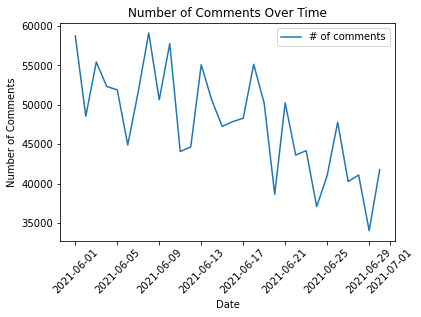

In [29]:
# visualize
df.toPandas()[['id','date_only']].sort_values(by ='date_only').groupby(by = 'date_only').count().plot(y ='id', rot = 45, label = '# of comments')
plt.title('Number of Comments Over Time')
plt.xlabel('Date') 
plt.ylabel('Number of Comments')

Most comments were posted at the start of the month, with the lowest number of comments posted towards the very end. 

#### `score`

Now let's explore the `score` variable. According to the data dictionary source linked above, this is the score (or karma) of the comment. What is karma? "You get Reddit Post Karma when people upvote anything that you post; you lose it when you get downvoted." (https://www.makeuseof.com/tag/what-is-reddit-karma/#:~:text=Reddit%20Karma%20is%20a%20score,Karma%20runs%20into%20the%20millions.)

Let's see the descriptive statistics of this variable.

In [30]:
df_full.select("score").summary("mean", "25%", "50%", "75%", "count", "min", "max").show()

+-------+-----------------+
|summary|            score|
+-------+-----------------+
|   mean|4.208884972605135|
|    25%|                1|
|    50%|                1|
|    75%|                2|
|  count|         20105228|
|    min|            -1913|
|    max|            17492|
+-------+-----------------+



In [31]:
# view the count of negative scores
df_full.filter(f.col("score") < 0).count()

1193012

The minimum value is negative (which is possible if there are more downvotes than upvotes for a comment). We can also see that the negative score is not a one-off event, since over 1 million comments have a negative score. 

The data also shows that on average, comments in the *unpopularopinion* subreddit receive a positive response (i.e. more upvotes than downvotes), as indicated by the positive mean.

#### `total_awards_received`

The variable `total_awards_received` denotes the number of awards received by the author of the comment. 

In [32]:
df_full.select("total_awards_received").summary("mean", "25%", "50%", "75%", "count", "min", "max").show()

+-------+---------------------+
|summary|total_awards_received|
+-------+---------------------+
|   mean| 0.001893835772466...|
|    25%|                    0|
|    50%|                    0|
|    75%|                    0|
|  count|             20105228|
|    min|                    0|
|    max|                  141|
+-------+---------------------+



The maximum number of awards received by an author of a comment are 141. Given the extremely low mean, it seems like awards are not earned easily in reddit. 

Let's see the correlation between this and the score of the comment. Again, I will be using the *df* dataset, with the assumption that it's a representative sample of the full dataset.

Text(0, 0.5, 'Total Awards of Comment Author')

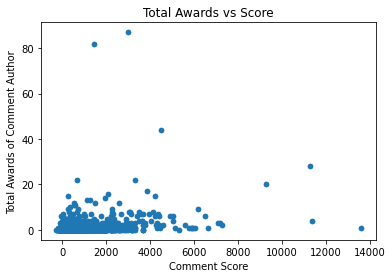

In [33]:
# visualize (scatter plot)
df.toPandas()[['total_awards_received','score']].plot.scatter(x='score', y='total_awards_received')
plt.title('Total Awards vs Score')
plt.xlabel('Comment Score') 
plt.ylabel('Total Awards of Comment Author') 

Overall, we can see that most comments in the *unpopularopinion* subreddit are posted by authors with less than 10 awards, followed by authors with awards between 10 and 15. The two comments with the highest scores are by authors with the lowest or close to the lowest number of awards. However, the comment with the third highest score is by an author with approximately 30 awards, so the correlation between the two variables doesn't seem too strong. 

We can also see that the highest number of awards (in the sample data that we are looking at), was more than 80, whereas the highest score was close to 14,000. 

Let's check the actual correlation.

In [34]:
# view correlation
df.toPandas()[['total_awards_received','score']].corr()

,total_awards_received,score
total_awards_received,1.000000,0.347342
score,0.347342,1.000000


Checking the actual correlation confirms what we saw in the scatterplot i.e. the correlation between total awards received by an author and the score of a comment is poor. This means that if one value goes up it does not mean that the other will.

Let's confirm that the sample dataset was a good represenation of the full dataset in this regard by calculating the correlation using the full dataset.

In [35]:
df_full.corr('total_awards_received', 'score')

0.26096244306829003

This correlation is close to the correlation figure of the sample dataset. 

#### `gilded`

In [36]:
# check unique values of gilded column
df_full.select('gilded').distinct().limit(10).collect()

[Row(gilded=5),
 Row(gilded=6),
 Row(gilded=9),
 Row(gilded=1),
 Row(gilded=3),
 Row(gilded=2),
 Row(gilded=0),
 Row(gilded=7),
 Row(gilded=8),
 Row(gilded=4)]

In [37]:
# check descriptive stats
df_full.select("gilded").summary("mean", "count", "min", "max").show()

+-------+--------------------+
|summary|              gilded|
+-------+--------------------+
|   mean|1.976600315102121...|
|  count|            20105228|
|    min|                   0|
|    max|                   9|
+-------+--------------------+



What is the `gilded` column showing? "Gilding or giving gold is an award you can give to someone on their post or comment." (https://www.reddit.com/r/TrophyWiki/comments/f0ps2c/reddit_trophy_gilding_ixi_all_gilding_trophies/).

Based on the figures above, it seems that the maximum gildings that someone has received on their comment (on the *unpopularopinion* subreddit) is 9, while the lowest is 0. On average, posts have almost 2 gildings. 

#### `gildings`

In [38]:
# check unique values of gildings column
df_full.select('gildings').distinct().limit(10).collect()

[Row(gildings='{}'),
 Row(gildings="{'gid_1': 4, 'gid_3': 1}"),
 Row(gildings="{'gid_1': 5, 'gid_2': 2, 'gid_3': 1}"),
 Row(gildings="{'gid_1': 1, 'gid_2': 1, 'gid_3': 1}"),
 Row(gildings="{'gid_1': 7, 'gid_2': 3, 'gid_3': 1}"),
 Row(gildings="{'gid_1': 4, 'gid_2': 1, 'gid_3': 1}"),
 Row(gildings="{'gid_1': 2, 'gid_2': 2, 'gid_3': 1}"),
 Row(gildings="{'gid_2': 1, 'gid_3': 2}"),
 Row(gildings="{'gid_3': 1}"),
 Row(gildings="{'gid_1': 4, 'gid_2': 1}")]

What is the `gildings` column showing? 

Based on what I have read about gildings and the 'data dictionary' source above, my interpretation is that this variable is capturing gildings that the author of the comment has/received. So {'gid_1': 1} would mean the author has received one guilding 1 title, and {'gid_2': 3} means the author has received 3 guilding 2 titles. 

### Correlation

Let's look at the correlation of all variables in the dataset. Once again, I'll be using the smaller dataset (for one month) with the assumption that it is a representative sample of the full dataset. 

<AxesSubplot:>

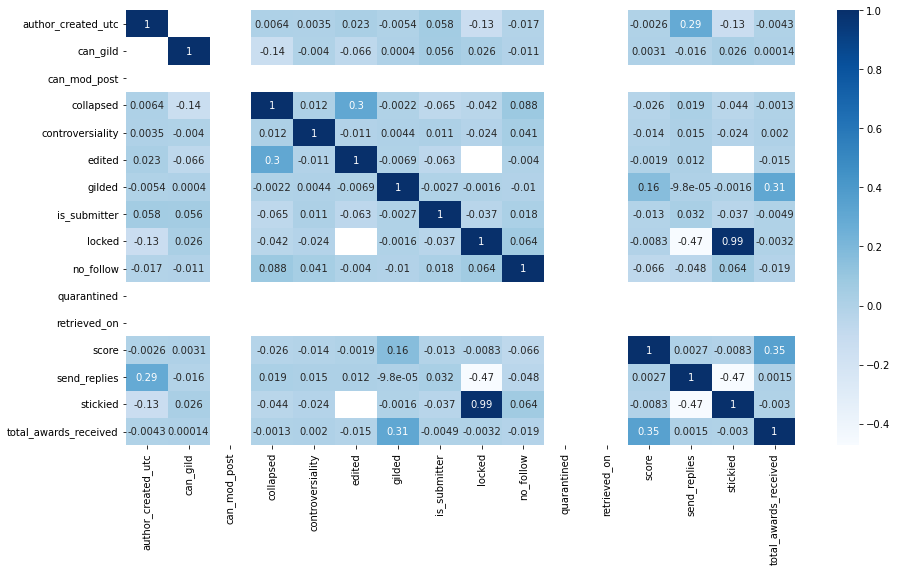

In [39]:
# visualize correlation matrix
plt.figure(figsize = (15,8))
sb.heatmap(df.toPandas().corr(), cmap="Blues", annot=True)

The strongest (almost perfect) correlation is between `locked` and `stickied`. `locked` denotes whether the thread (which the comment is a part of) has been locked, while `stickied` denotes 'sticky posts' (which are announcements, not posts). Based on the almost perfect correlation, a significant and positive relationship exists between the two.

The correlation between `locked` and `send_replies` (which denotes whether the author of the comment accepts replies) is moderate (-0.47). The negative correlation indicates that there is a moderate, negative relationship between these two variables.

As we saw earlier, the correlation between `score` and `total_awards_received` denotes a positive but weak relationship between the two variables. We can also see that the correlation between `total_awards_received` and `gilded` is positive and weak.

### Text

Get a quick peek at the data at the `body` column, which seems to denote the main text of the comment:

In [40]:
df_full[['body']].show(5)

+--------------------+
|                body|
+--------------------+
|Ok Karen.

It’s f...|
|Every modern fema...|
|Well assuming the...|
|Most def!!!! She ...|
|It’s really dumb ...|
+--------------------+
only showing top 5 rows



Can't view the whole text - let's try again and view the full text of 5 rows. 

In [41]:
list(df_full.withColumn('ID', f.monotonically_increasing_id()).sort('ID').limit(10).toPandas().iloc[0:5,:].body.values)

['Ok Karen.\n\nIt’s funny when people like you get ignored at the bar, and then wonder why they aren’t getting service.\n\nI bet you love to make tons of special requests and changes to items on the menu.\n\nKeep your broke ass at home if you can’t afford to tip your server. - serious advice - if you can’t afford to tip $1.50 on a $10.00 meal; stay the fuck home and save your money.',
 'Every modern female character has to have a scene showing how “competent” they are or else women everywhere will lose all the self-confidence they have or something',
 'Well assuming the story was true, the three guys can seriously lawyer up and sue the company for unfair dismissal. Who the fuck gets fired for hearsay? If that is the case the the HR department really messed it up. I mean literally anyone could get anyone fired in that company. \n\nUsually the wrong doing has to be proven beyond doubt and they just fired the guys without given them a chance to defend themselves. The OP in that post was a

### Pre-processing Text


In [42]:
from pyspark.sql.functions import lower
from pyspark.ml.feature import Tokenizer

#### Convert to lower case

In [43]:
# convert text column to lower case 
df_full = df_full.withColumn('body', lower(df_full.body))

### Top Nouns

Create a binary variable that indicates whether the comment text contains one or more of the top 3 nouns of the unpopularopinion subreddit. As of May 3, 2022, these three top nouns were people, kids, and women (https://sandhoefner.github.io/reddit/).

In [44]:
# create a binary variable 
df_full = df_full.withColumn("top_nouns",f.when((df_full.body.contains('people')) | (df_full.body.contains('women')) | (df_full.body.contains('kids')), 1).otherwise(0))


In [45]:
# check label counts
df_full.groupby('top_nouns').count().collect()

[Row(top_nouns=1, count=3739552), Row(top_nouns=0, count=16365676)]

Over 3 million comments use one or more of the top 3 nouns. 

### Word Count

Create a column storing the word count of each comment (including stop words since I am interested in looking at the length of a comment, which can be increased using stop words).

**1. Tokenize the comment**

Tokenization is the process of taking text (such as a sentence) and breaking it into individual terms (usually words). Let's tokenize the messages and create a list of words of each message.

In [46]:
# store tokenizer
tokenizer = Tokenizer(inputCol = "body", outputCol = "words")

# transform text column
df_full = tokenizer.transform(df_full)

In [47]:
df_full = df_full.withColumn('word_count', f.size(f.col('words')))

In [48]:
# check descriptive stats
df_full.select("word_count").summary("mean", "count", "min", "max").show()

+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|   mean|34.38919071198794|
|  count|         20105228|
|    min|                1|
|    max|             2792|
+-------+-----------------+



The maximum word count is 2792, whereas the average comment has around 34 words (including stop words). 

----

## Model 1 - Decision Tree Regressor

In [49]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

---

### Model
*y*: score (int)

*x*:
- word_count
- top_nouns
- total_awards_received
- gilded
- is_weekend
- controversiality
- distinguished

In [50]:
# select only the relevant variables for the model and store 
df1 = df_full[['score','word_count', 'top_nouns', 'total_awards_received','gilded',
               'is_weekend', 'controversiality', 'distinguished']]

Remove the remaining missing data so that the dataset can be split into a training and test set. 

In [51]:
# remove missing data
df1 = df1.dropna()

### Split Data into Train and Test Sets

In [52]:
train_data, test_data = df1.randomSplit([0.8, 0.2], 24)

View the number of rows in training and test data:

In [53]:
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 16083948


Number of testing records : 4021280


`distinguished`

In [54]:
# convert string to numeric indices
stringIndexer_distinguished = StringIndexer(inputCol = "distinguished",
                                            outputCol = "distinguished_ix")

### training data
# fit StringIndexer
dist_fit = stringIndexer_distinguished.fit(train_data)
train_data = dist_fit.transform(train_data)

### test data
# fit StringIndexer
dist_fit = stringIndexer_distinguished.fit(test_data)
test_data = dist_fit.transform(test_data)

#### Vector Assembler

In the following step, create a feature vector by combining all the features together using the `vectorAssembler` method.

In [55]:
vectorAssembler_features = VectorAssembler(inputCols = ['word_count', 'top_nouns', 'total_awards_received',
                                                        'gilded', 'is_weekend', 'controversiality',
                                                        'distinguished_ix'], 
    outputCol = "features")

In [56]:
# apply vector assembler - training data
train_data1 = vectorAssembler_features.transform(train_data)

In [57]:
# apply vector assembler - test data
test_data1 = vectorAssembler_features.transform(test_data)

In [58]:
# view data
train_data1.select(['features','score']).show(3)

+--------------------+-----+
|            features|score|
+--------------------+-----+
|       (7,[0],[6.0])| -309|
|      (7,[0],[26.0])| -293|
|(7,[0,4],[15.0,1.0])| -234|
+--------------------+-----+
only showing top 3 rows



In [59]:
# define decision tree regressor
dt = DecisionTreeRegressor(featuresCol = "features", labelCol = "score")

In [60]:
# fit decision tree regressor on training data 
model_dt = dt.fit(train_data1)

In [61]:
# make predictions
predictions = model_dt.transform(test_data1)

In [62]:
# select example rows to display
predictions.select("prediction", "score", "features").show(5)

+----------------+-----+--------------------+
|      prediction|score|            features|
+----------------+-----+--------------------+
|4.28985315572926| -142|      (7,[0],[11.0])|
|4.28985315572926| -119|      (7,[0],[56.0])|
|4.28985315572926|  -99|       (7,[0],[6.0])|
|4.28985315572926|  -92|(7,[0,1],[89.0,1.0])|
|4.28985315572926|  -73|(7,[0,1],[32.0,1.0])|
+----------------+-----+--------------------+
only showing top 5 rows



In [63]:
# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol = "score",
    predictionCol = "prediction",
    metricName = "rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 50.8886


The decision tree regressor has no summary object, but we can look at the root mean squared error. Although it seems high, the RSME is context-dependent. In this case, since scores have a wide range, an error of approximately 51 is not too bad, although it itsn't great either. 

## Model 2 - Random Forest Classifier

Now, let's create a binary variable with a value of 1 if the score of the comment is above average, and 0 if it is equal to or below average. This would be our *y*.

The independent variables would include all of the previous ones. It should be noted that the text was pre-processed and vectorized and added as an independent variable. However, that led to extremely long running time for the models, so I decided not to include that.  

In [64]:
# select only the relevant variables for the model and store 
df2 = df_full[['score', 'word_count', 'top_nouns', 'total_awards_received','gilded',
               'is_weekend', 'controversiality', 'distinguished']]

In [65]:
# check average of score column
df2.select("score").summary("mean", "min", "max").show()

+-------+-----------------+
|summary|            score|
+-------+-----------------+
|   mean|4.208884972605135|
|    min|            -1913|
|    max|            17492|
+-------+-----------------+



The average score is 4.2. Comments with a score greater than this will be labeled 1, whereas those with a score less than or equal to 4.2 will be labeled 0. 

In [66]:
# create and store label column
df2 = df2.withColumn("label",
                     f.when((df2.score > 4.2), 1).otherwise(0))

In [67]:
# check Schema
df2.printSchema()

root
 |-- score: long (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- top_nouns: integer (nullable = false)
 |-- total_awards_received: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- label: integer (nullable = false)



In [68]:
# check label counts
df2.groupby('label').count().collect()

[Row(label=1, count=2554288), Row(label=0, count=17550940)]

In [69]:
# remove missing data
df2 = df2.dropna()

In [70]:
# store the majority and minority class counts
ratio = (df2.filter(df2.label == 0).count() / df2.filter(df2.label == 1).count())

# view ratio
ratio

6.871167229380555

The dataset is imbalanced since which can cause the model to blindly predict the dominant class since it can achieve good accuracy that wat. To combat this, I will be undersampling the majority class (where `label` = 0).

In [71]:
# store majority and minority class
major_df = df2.filter(df2.label == 0)
minor_df = df2.filter(df2.label == 1)

# undersample majority class
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(minor_df)
combined_df_2.show(2)

+-----+----------+---------+---------------------+------+----------+----------------+-------------+-----+
|score|word_count|top_nouns|total_awards_received|gilded|is_weekend|controversiality|distinguished|label|
+-----+----------+---------+---------------------+------+----------+----------------+-------------+-----+
|    1|        27|        1|                    0|     0|         1|               0|         None|    0|
|    0|         9|        0|                    0|     0|         1|               0|         None|    0|
+-----+----------+---------+---------------------+------+----------+----------------+-------------+-----+
only showing top 2 rows



### Split Data into Train and Test Sets

In [72]:
train_data, test_data = combined_df_2.randomSplit([0.8, 0.2], 24)

In [73]:
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 4084175


Number of testing records : 1022857


`distinguished`

In [74]:
# convert string to numeric indices
stringIndexer_distinguished = StringIndexer(inputCol = "distinguished",
                                            outputCol = "distinguished_ix")

### training data
# fit StringIndexer
dist_fit = stringIndexer_distinguished.fit(train_data)
train_data = dist_fit.transform(train_data)

### test data
# fit StringIndexer
dist_fit = stringIndexer_distinguished.fit(test_data)
test_data = dist_fit.transform(test_data)

#### Fitting Model

In [75]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

In [76]:
vectorAssembler_features = VectorAssembler(inputCols = ['word_count', 'top_nouns', 'total_awards_received',
                                                        'gilded', 'is_weekend', 'controversiality',
                                                        'distinguished_ix'], 
    outputCol = "features")

In [77]:
# apply vector assembler - training data
train_data1 = vectorAssembler_features.transform(train_data)

In [78]:
# apply vector assembler - test data
test_data1 = vectorAssembler_features.transform(test_data)

In [79]:
# view data
train_data1.select(['features','label']).show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|       (7,[0],[3.0])|    0|
|(7,[0,4],[34.0,1.0])|    0|
| (7,[0,4],[9.0,1.0])|    0|
+--------------------+-----+
only showing top 3 rows



In [80]:
from pyspark.ml.classification import RandomForestClassifier

# specify RF classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)

In [81]:
# fit model
model_rf = rf.fit(train_data1)

In [82]:
# make predictions
predictions = model_rf.transform(test_data1)

In [83]:
# evaluation
area_under_roc = BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderROC")
area_under_roc.evaluate(predictions)

0.6072257897520338

An excellent model has AUC near to 1, a poor model has AUC near 0, whereas an AUC of 0.5 means that the model has no class separation capacity whatsoever. Based on this, the model's AUC of 0.6 shows the the model has some class separation capacity, but is not very strong. 

In [84]:
# MulticlassClassificationEvaluator can be used for binary classification as well
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1score = MulticlassClassificationEvaluator().setLabelCol("label").setMetricName('f1')
f1score.evaluate(predictions)

0.5304826603699209

The best F1 score is 1 and the worst is 0. 0.5 is in the middle, but interpreting it requires looking at the research question. 

In [85]:
accuracy = MulticlassClassificationEvaluator().setLabelCol("label").setMetricName('accuracy')
accuracy.evaluate(predictions)

0.5838910033367323

Out of all data points, approximately 58% were predicted correctly. This is better than chance, but not a very strong performance.

### Stop EMR 

In [ ]:
spark.stop()